In [99]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from modules import get_bandpass_dict, Sed
from scipy.integrate import simps
#from scipy.signal import medfilt
#from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline

In [98]:
scipy.interpolate.UnivariateSpline?

Init signature:
scipy.interpolate.UnivariateSpline(
    x,
    y,
    w=None,
    bbox=[None, None],
    k=3,
    s=None,
    ext=0,
    check_finite=False,
)
Docstring:     
One-dimensional smoothing spline fit to a given set of data points.

Fits a spline y = spl(x) of degree `k` to the provided `x`, `y` data.  `s`
specifies the number of knots by specifying a smoothing condition.

Parameters
----------
x : (N,) array_like
    1-D array of independent input data. Must be increasing;
    must be strictly increasing if `s` is 0.
y : (N,) array_like
    1-D array of dependent input data, of the same length as `x`.
w : (N,) array_like, optional
    Weights for spline fitting.  Must be positive.  If None (default),
    weights are all equal.
bbox : (2,) array_like, optional
    2-sequence specifying the boundary of the approximation interval. If
    None (default), ``bbox=[x[0], x[-1]]``.
k : int, optional
    Degree of the smoothing spline.  Must be <= 5.
    Default is k=3, a cubic spli

In [97]:
dir(scipy.interpolate)

['Akima1DInterpolator',
 'BPoly',
 'BSpline',
 'BarycentricInterpolator',
 'BivariateSpline',
 'CloughTocher2DInterpolator',
 'CubicHermiteSpline',
 'CubicSpline',
 'InterpolatedUnivariateSpline',
 'KroghInterpolator',
 'LSQBivariateSpline',
 'LSQSphereBivariateSpline',
 'LSQUnivariateSpline',
 'LinearNDInterpolator',
 'NdPPoly',
 'NearestNDInterpolator',
 'PPoly',
 'PchipInterpolator',
 'Rbf',
 'RectBivariateSpline',
 'RectSphereBivariateSpline',
 'RegularGridInterpolator',
 'SmoothBivariateSpline',
 'SmoothSphereBivariateSpline',
 'UnivariateSpline',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_bspl',
 '_bsplines',
 '_cubic',
 '_fitpack',
 '_fitpack_impl',
 '_pade',
 '_ppoly',
 'absolute_import',
 'approximate_taylor_polynomial',
 'barycentric_interpolate',
 'bisplev',
 'bisplrep',
 'dfitpack',
 'division',
 'fitpack',
 'fitpack2',
 'griddata',
 'insert',
 'interp1d',
 'interp2d',
 'inter

In [7]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

In [59]:
bandpass_dict = get_bandpass_dict(dlambda=10)

The trained N8 templates before spectral line reconstruction

![N8 Trained](plots/N8_trained.png)

I am going to try to reconstruct the spectral lines in N8_6, N8_7, and N_8.

In [13]:
original_templates = dict()
for i in range(1,9):
    name = 'N8_'+str(i)
    x,y = np.loadtxt('templates/'+name+'.sed',unpack=True)
    original_templates[name] = Sed(x,y)

Functions for spectral line reconstruction

In [35]:
FWHM = 20
sig = FWHM/2.355

def idx_closest(x,array):
    return np.fabs(np.array(array)-x).argmin()

Start with N8_8

18.1135


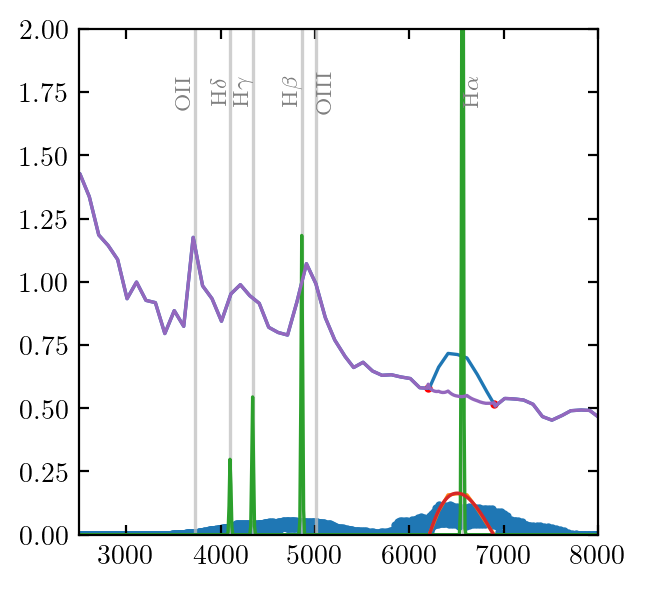

In [130]:
template = copy.deepcopy(original_templates['N8_8'])

plt.plot(template.wavelen,template.flambda)

box_style = dict(facecolor='none', edgecolor='none', pad=0)
# Halpha
plt.vlines(6563,0,10,color='silver',alpha=0.75) # Halpha
plt.text(6563,1.75,r"H$\alpha$",fontsize=8,rotation=90,
         color='gray',ha='left',va='center',bbox=box_style)
# Hbeta   
plt.vlines(4861,0,10,color='silver',alpha=0.75) # Hbeta
plt.text(4861,1.75,r"H$\beta$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center')       
# OIII
plt.vlines(5007,0,10,color='silver',alpha=0.75) # OIII
plt.text(5007,1.75,"OIII",fontsize=8,rotation=90,
         color='gray',ha='left',va='center')
# OII
plt.vlines(3727,0,10,color='silver',alpha=0.75) # OII
plt.text(3727,1.75,"OII",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)
# Hdelta
plt.vlines(4102,0,2.1,color='silver',alpha=0.75) # Hdelta
plt.text(4102,1.75,r"H$\delta$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)
# Hgamma
plt.vlines(4340,0,2.1,color='silver',alpha=0.75) # Hgamma
plt.text(4340,1.75,r"H$\gamma$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)


idx_lo = idx_closest(6200,template.wavelen)
plt.scatter(template.wavelen[idx_lo],template.flambda[idx_lo],c='r')

idx_hi = idx_closest(6900,template.wavelen)
plt.scatter(template.wavelen[idx_hi],template.flambda[idx_hi],c='r')

subtrX = template.wavelen[idx_lo:idx_hi+1].copy()
subtrY = template.flambda[idx_lo:idx_hi+1].copy()
continuum = np.interp(subtrX,[subtrX[0],subtrX[-1]],[subtrY[0],subtrY[-1]])
subtrY -= continuum

plt.plot(subtrX,subtrY)

Ha_scale = simps(subtrY,subtrX)
Hb_scale = 0.35*Ha_scale
Hd_scale = 0.09*Ha_scale
Hg_scale = 0.16*Ha_scale

print(Hd_scale+Hg_scale)

Hlines = Ha_scale*norm.pdf(template.wavelen,6563,sig) +\
         Hb_scale*norm.pdf(template.wavelen,4861,sig) +\
         Hd_scale*norm.pdf(template.wavelen,4102,sig) +\
         Hg_scale*norm.pdf(template.wavelen,4340,sig)

plt.plot(template.wavelen,Hlines)

spl = UnivariateSpline(subtrX,subtrY)
plt.plot(subtrX,spl(subtrX))

template.flambda[idx_lo:idx_hi+1] -= spl(template.wavelen[idx_lo:idx_hi+1])
plt.plot(template.wavelen,template.flambda)

wavelens = np.array([])
fluxes = np.array([])
for z in np.linspace(0,3,500):
    lineSED_ = copy.deepcopy(lineSED)
    lineSED_.redshift(z)
    #bands = ['y']
    bands = list(bandpass_dict.keys())
    wavelens_ = [bandpass_dict[band].eff_wavelen/(1+z) for band in bands]
    fluxes_ = lineSED_.fluxlist(bandpass_dict,bands)
    wavelens = np.concatenate((wavelens,wavelens_))
    fluxes = np.concatenate((fluxes,fluxes_))
    
plt.scatter(wavelens,fluxes)

plt.xlim(2500,8000)
plt.ylim(0,2)
plt.show()

46.52825000000001


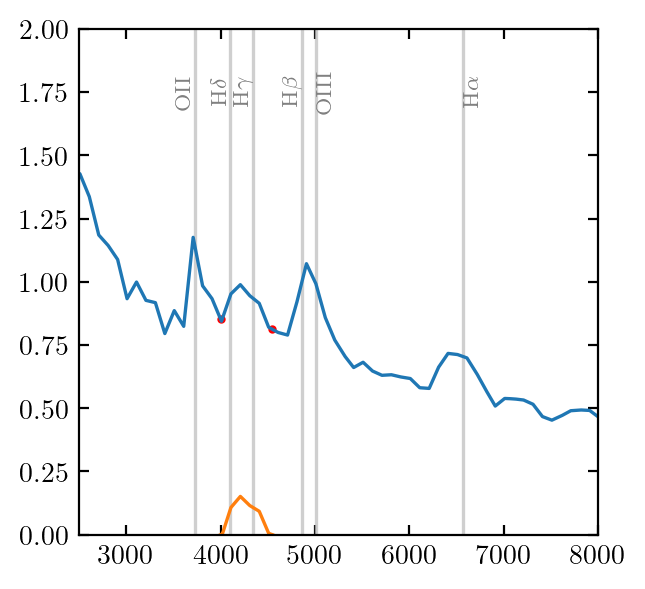

In [118]:
template = copy.deepcopy(original_templates['N8_8'])

plt.plot(template.wavelen,template.flambda)

box_style = dict(facecolor='none', edgecolor='none', pad=0)
# Halpha
plt.vlines(6563,0,10,color='silver',alpha=0.75) # Halpha
plt.text(6563,1.75,r"H$\alpha$",fontsize=8,rotation=90,
         color='gray',ha='left',va='center',bbox=box_style)
# Hbeta   
plt.vlines(4861,0,10,color='silver',alpha=0.75) # Hbeta
plt.text(4861,1.75,r"H$\beta$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center')       
# OIII
plt.vlines(5007,0,10,color='silver',alpha=0.75) # OIII
plt.text(5007,1.75,"OIII",fontsize=8,rotation=90,
         color='gray',ha='left',va='center')
# OII
plt.vlines(3727,0,10,color='silver',alpha=0.75) # OII
plt.text(3727,1.75,"OII",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)
# Hdelta
plt.vlines(4102,0,2.1,color='silver',alpha=0.75) # Hdelta
plt.text(4102,1.75,r"H$\delta$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)
# Hgamma
plt.vlines(4340,0,2.1,color='silver',alpha=0.75) # Hgamma
plt.text(4340,1.75,r"H$\gamma$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)


idx_lo = idx_closest(4000,template.wavelen)
plt.scatter(template.wavelen[idx_lo],template.flambda[idx_lo],c='r')

idx_hi = idx_closest(4550,template.wavelen)
plt.scatter(template.wavelen[idx_hi],template.flambda[idx_hi],c='r')

subtrX = template.wavelen[idx_lo:idx_hi+1].copy()
subtrY = template.flambda[idx_lo:idx_hi+1].copy()
continuum = np.interp(subtrX,[subtrX[0],subtrX[-1]],[subtrY[0],subtrY[-1]])
subtrY -= continuum

plt.plot(subtrX,subtrY)
print(simps(subtrY,subtrX))

"""
Ha_scale = simps(subtrY,subtrX)
Hb_scale = 0.35*Ha_scale
Hd_scale = 0.09*Ha_scale
Hg_scale = 0.16*Ha_scale

Hlines = Ha_scale*norm.pdf(template.wavelen,6563,sig) +\
         Hb_scale*norm.pdf(template.wavelen,4861,sig) +\
         Hd_scale*norm.pdf(template.wavelen,4102,sig) +\
         Hg_scale*norm.pdf(template.wavelen,4340,sig)

plt.plot(template.wavelen,Hlines)

spl = UnivariateSpline(subtrX,subtrY)
plt.plot(subtrX,spl(subtrX))

template.flambda[idx_lo:idx_hi+1] -= spl(template.wavelen[idx_lo:idx_hi+1])
plt.plot(template.wavelen,template.flambda)
"""

plt.xlim(2500,8000)
plt.ylim(0,2)
plt.show()